In [227]:
import numpy as np
import matplotlib
import scipy
import scipy.special as sp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
from focused_beams_class import *
from planewave import *
from domain_class import *
from displaced_beams import *
from mie import *
from Multipoles import *
import numba
import scipy
import numba_scipy

print("Numba version:", numba.__version__)
print("SciPy version:", scipy.__version__)
print("Numba-Scipy version:", numba_scipy.__version__)
print("Numpy Version:", np.__version__)
print("Matplotlib Version", matplotlib.__version__)



## Define Standard Units
fsize = 22
tsize = 15
tdir = 'in'
major = 5
minor = 3
style = 'default'

params = {
    'figure.figsize': (15,12),
    'savefig.dpi': 75,
    'text.usetex': False,
    'font.size': fsize,
    'legend.fontsize': tsize,
    'legend.title_fontsize': tsize,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral',    
    'axes.labelsize':15,
    'axes.titlesize':20,
    'lines.linewidth':2.5,
    'axes.grid': False,
    'axes.labelweight':'bold',
    'legend.loc': 'upper right',
    'xtick.labelsize':'x-small',
    'ytick.labelsize':'x-small',
}
plt.rcParams.update(params)

class interaction(Multipoles):
    def __init__(self, beam, domain, nr, radius, mu = 1, mu1 = 1, interaction = "both"):
        self.beam_params = beam.beam_params
        self.beamtype = self.beam_params["type"]
        self.maxJ = self.beam_params["maxJ"]
        self.wl = self.beam_params["wl"]
        self.l_max = self.maxJ
        self.m_max = self.maxJ
        self.rr = radius
        super().__init__(self.l_max, self.m_max, self.wl, domain, nr=nr, radius=radius)
        self.nr = nr
        self.spherical_grids = domain.spherical_grid()
        self.size = domain.size
        self.planes = self.spherical_grids.keys()
        
        self.mz_star = self.beam_params["mz_star"]
        self.j0 = max(abs(self.mz_star), 1)
        
        if self.beamtype == "planewave":
            self.C = np.ones(self.maxJ+1)
        elif self.beamtype == "focused":
            self.p = self.beam_params["p"]
            self.C = beam.C
        elif self.beamtype == "displaced":
            self.p = self.beam_params["p"]
            self.C = beam.C_off
        else:
            raise ValueError("Beam type not implemented")
        
        self.k = 2*np.pi/self.wl
        self.x = self.k * self.rr
        
        self.mu = mu
        self.mu1 = mu1

        
        self.mie = glmt(self.maxJ, self.wl, self.nr, self.x, self.mu, self.mu1)
        
        #mie coefficients
        self.a = self.mie.a_j()
        self.b = self.mie.b_j()
        self.c = self.mie.c_j()
        self.d = self.mie.d_j()

        # Initialize SCA and ABS arrays with ones, same shape as R
        SCA = np.ones_like(self.R)
        ABS = np.ones_like(self.R)
        
        # Find indices where values are less than or greater than rr
        index1 = np.where(self.R < self.rr)
        index2 = np.where(self.R > self.rr)

        # Set values in ABS and SCA arrays based on indices
        ABS[index2] = 0
        SCA[index1] = 0
        
        if interaction == "scattering":
            self.spatial_fun = "hankel"
            self.S = SCA
        elif interaction == "internal":
            self.spatial_fun = "bessel"
            self.S = ABS
        elif interaction == "both":
            self.spatial_fun = "both"
            self.S = np.ones_like(self.R)
        else:
            raise ValueError("type must be 'scattering' or 'internal'")
        
    def _is_equal(self, a, b):
            """
            Helper function to check equality between two inputs.
            Returns True if:
            1. Both are arrays and are equal.
            2. Both are scalars and are equal.
            Returns False if:
            1. Arrays are unequal.
            2. Scalars are unequal.
            3. One is an array and the other is a scalar.
            """
            if np.isscalar(a) and np.isscalar(b):
                return a == b
            elif isinstance(a, np.ndarray) and isinstance(b, np.ndarray):
                return np.array_equal(a, b)
            else:
                return False
            
    def compute_sum(self):
        assert self.a.ndim == 1, "a must be 1D"
        #initial multipole
        j0 = self.j0

        

        if (self.beamtype == "plane") or (self.beamtype == "focused"):
            Js = np.arange(self.maxJ+1)
            coefs = 1j**Js * np.sqrt(2*Js+1)
            prefac = (self.C.T * coefs).T

            mp0 = self.get_multipoles(j0, self.mz_star, self.spatial_fun)
            
            mp0["magnetic"] *= prefac[j0] * (self.b[j0] * self.SCA + self.c[j0] * self.ABS)
            mp0["electric"] *= prefac[j0] *(self.a[j0] * self.SCA + self.d[j0] * self.ABS)
    
            for j in range(j0+1, self.maxJ):
                mp = self.get_multipoles(j, self.mz_star, self.spatial_fun)
                
                mp0["magnetic"] += prefac[j] *(self.b[j] * self.SCA + self.c[j] * self.ABS)* mp["magnetic"] 
                mp0["electric"] += prefac[j] *(self.a[j] * self.SCA + self.d[j] * self.ABS)* mp["electric"]

            sum = mp0["magnetic"]+(1j)* self.p * mp0["electric"]
            
        elif self.beamtype == "displaced":
            Js = np.arange(j0, self.maxJ+1)
            coefs = 1j**Js * np.sqrt(2*Js+1)
            prefac = (self.C.T * coefs).T
            
            mp0 = self.get_multipoles(j0, self.mz_star, self.spatial_fun)
            
            mp0["magnetic"] *= 0
            mp0["electric"] *= 0

            for j in range(j0, self.maxJ):
                nn = 0
                a = self.a[j]
                b = self.b[j]
                c = self.c[j]
                d = self.d[j]
                for m in range(-j, j + 1):
                    mp = self.get_multipoles(j, m, self.spatial_fun)

                    mp0["magnetic"] += prefac[j, nn] *(b * self.SCA + c * self.ABS)* mp["magnetic"]
                    mp0["electric"] += prefac[j, nn] *(a * self.SCA + d * self.ABS)* mp["electric"]
                    nn += 1
                    
            sum = mp0["magnetic"] + (1j) * self.p * mp0["electric"]
            
            
        return sum
    
    def getCrossSection(self, type="scattering", dims = 1, includeParts = False, plot = True, **kwargs):
        """Compute the cross section of the multipoles.
        
        Args:
            type (str, optional): Type of cross section to compute. Defaults to "scattering". Can also be "internal" or "extinction".
            dims (int, optional): Number of dimensions of cross-section. Defaults to 1.
            includeParts (bool, optional): If True, return return a (4, maxJ, dims) matrix containing all multipolar contributions.
            plot (bool, optional): If True, plot the cross section. Defaults to True.
            **kwargs: Optional parameters to override x, radius, nr, or wl.

        Raises:
            ValueError: type must be 'scattering', 'internal' or 'extinction'
        
        Returns: 
            Array of cross sections for the specified type.
        """
        glmt_dims = None
        
        if dims not in [0, 1, 2]:
            raise ValueError("dims must be 0, 1 or 2")
        
        if  not kwargs:
            wl = self.wl
            radius = self.rr
            x = self.x
            nr = self.nr
            xdim = radiusdim = nrdim = wldim = 0
        
        else:
            # Check if kwargs contains 'x', 'radius', 'nr', or 'wavelength' and pop them
            if "x" in kwargs:
                x = kwargs.pop("x")
                x = np.asarray(x)  # Ensure x is an array
            else:
                x = np.asarray(getattr(self, "x", None))
            xdim = x.ndim
            if "radius" in kwargs:
                radius = kwargs.pop("radius")
                radius = np.asarray(radius)  # Ensure radius is an array
            else:
                radius = np.asarray(getattr(self, "rr", None))
            radiusdim = radius.ndim
            if "nr" in kwargs:
                nr = kwargs.pop("nr")
                nr = np.asarray(nr)
            else:
                nr = np.asarray(getattr(self, "nr", None))
            nrdim = nr.ndim
            if "wavelength" in kwargs:
                wl = kwargs.pop("wavelength")
                wl = np.asarray(wl)
            else:
                wl = np.asarray(getattr(self, "wl", None))
            wldim = wl.ndim
 
        dimsum = xdim + radiusdim + nrdim + wldim
        
        
        # check if refractive index and wavelength are coupled
        if ((nrdim == 1) and (wldim == 1)) and (dims == 1):
            print("Assuming wavelength dependent refractive index.")
            axis1 = wl
            axis1label = "Wavelength (µm)"
            glmt_dims = 1
            dimsum -= 1
        elif ((nrdim == 1) and (wldim == 1)) and (dims == 2):
            print("Assuming independent wavelength and refractive index.")
            axis1 = wl
            axis1label = "Wavelength (µm)"
            axis2 = nr
            axis2label = "Refractive Index (nr)"
            
        # Check if the total number of dimensions matches the expected dimensions
        if dimsum != dims:
            raise ValueError("Expected at {} dimensions, got {}.".format(dims, dimsum))
        if dims == 0:
            x = np.asarray(x)
        
        # Print constant beam parameters
        self.printConstantBeamParams(x, wl, radius, nr)
        
        if (xdim == 1):
            if ((radiusdim == 1) or (wldim == 1)):
                dims -= 1
            else:
                print("Size parameter provided. Using size parameter for 1D cross section.\n")
            
            if radiusdim == 1:
                if (len(x) != len(radius)):
                    raise ValueError("Size parameter x must have the same length as radius.")
                print("Size parameter and radiusprovided. Using only size parameter for 1D cross section.\n")
                wl = 2 * np.pi * radius / x
            elif wldim == 1:
                if  (len(x) != len(wl)):
                    raise ValueError("Size parameter x must have the same length as wavelength.")
                print("Size parameter and wavelength provided. Using only size parameter for 1D cross section.\n")
                radius = wl * x / (2 * np.pi)
                
            axis1 = x
            axis1label = "Size Parameter (x)"
        #calculate x
        if not xdim == 1:
            if (radiusdim == 1) and (wldim == 1):
                print("Calculating new size parameter array from radius and wavelength for 1D cross section.\n")
                minx = 2 * np.pi * min(radius) / max(wl)
                maxx = 2 * np.pi * max(radius) / min(wl)
                x = np.linspace(minx, maxx, 1000)
                axis1 = x
                axis1label = "Size Parameter (x)"
            else:
                if (radiusdim == 1) and (nrdim == 1):
                    print("Calculating new size parameter array from radius and refractive index for 2D cross section.\n")
                    x = 2 * np.pi * radius / wl
                    axis1 = radius
                    axis1label = "Radius (µm)"
                    axis2 = nr  
                    axis2label = "Refractive Index (nr)"
                elif ((wldim == 1) and (nrdim == 1)):
                    if dims == 2:
                        print("Calculating new size parameter array from refractive index and wavelength for 2D cross section.\n")
                        axis2 = nr
                        axis2label = "Refractive Index (nr)"
                    elif dims == 1: 
                        print("Calculating new size parameter array from refractive index and wavelength for 1D cross section.\n")
                    x = 2 * np.pi * radius / wl
                    axis1 = wl
                    axis1label = "Wavelength (µm)"
                elif nrdim == 1:
                    print("Calculating new size parameter array from radius, refractive index and wavelength for 1D cross section.\n")
                    x = 2 * np.pi * radius * nr / wl
                    axis1 = nr
                    axis1label = "Refractive Index (nr)"
                elif wldim == 1:
                    print("Calculating new size parameter array from radius, refractive index and wavelength for 1D cross section.\n")
                    x = 2 * np.pi * radius / wl
                    axis1 = wl
                    axis1label = "Wavelength (µm)"

        
        mie = glmt(self.maxJ, wl, np.asarray(nr), x, dim = glmt_dims)
        #calculate mie coefficients as a function of x
        a = mie.a_j()
        b = mie.b_j()
        c = mie.c_j()
        d = mie.d_j()

        k = 2 * np.pi / wl 
        
        if type == "scattering":
            #ensure C is 2D to make matrix multiplication work
            if self.C.ndim == 1:
                C = self.C[1:, None]
            L = np.arange(1, len(C)+1)
            coefs = (2 * L + 1)[:, None]  # Ensure coefs is 2D for broadcasting
            prefac = (coefs * np.abs(C)**2).T

            # Expand prefac to match the shape of a for broadcasting
            while prefac.ndim -1 < a.ndim:
                prefac = np.expand_dims(prefac, axis=-1)
            
            included_e = prefac * np.expand_dims(np.abs(a[1:])**2, axis = 0) 
            included_m = prefac * np.expand_dims(np.abs(b[1:])**2, axis = 0) 
            
            Ws = 2 * np.pi * np.sum(included_e.copy() + included_m.copy(), axis=(0, 1))/ k**2 #sum over J and mZ

            W = Ws
    
        elif type == "internal":
            #ensure C is 2D to make matrix multiplication work
            if self.C.ndim == 1:
                C = self.C[1:, None]
            L = np.arange(1, len(C)+1)
            coefs = (2 * L + 1)[:, None]
            
            prefac = (0.5 * coefs * np.abs(C)**2).T
            
            # Expand prefac to match the shape of c/d for broadcasting
            while prefac.ndim -1 < c.ndim:
                prefac = np.expand_dims(prefac, axis=-1)
            
            included_m = prefac * np.expand_dims(np.abs(c[1:])**2, axis = 0) 
            included_e = prefac * np.expand_dims(np.abs(d[1:])**2, axis = 0) 
            
            Wint = 2 * np.pi * np.sum(included_e.copy() + included_m.copy(), axis=(0, 1)) / k**2 #sum over J and mZ
         
            W = Wint

        elif type == "extinction":
            if self.C.ndim == 1:
                C = self.C[1:, None]
            L = np.arange(1, len(C) + 1)
            coefs = (2 * L + 1)[:, None]
            
            prefac = (0.5 * coefs * np.abs(C)**2).T

            while prefac.ndim -1 < a.ndim:
                prefac = np.expand_dims(prefac, axis=-1)
    
            
            included_e = np.expand_dims(a[1:], axis = 0) 
            included_m = np.expand_dims(b[1:], axis = 0) 
            Wext = prefac * np.real(included_m.copy() + included_e.copy())
            Wext = 4 * np.pi * np.sum(Wext, axis=(0, 1))/ k**2 #sum over J and mZ
            W = Wext
        
        else:
            raise ValueError("type must be 'scattering', 'internal' or 'extinction'")
    
        included_e, included_m = included_e.squeeze(), included_m.squeeze()
        
        # For each j in included_e and included_m, scale the row by the ratio of its max to the value of W at the same index
        for j in range(included_e.shape[0]):
            max_e = np.max(included_e[j])
            max_m = np.max(included_m[j])
            idx_e = np.argmax(included_e[j])
            idx_m = np.argmax(included_m[j])
            # scale 
            included_e[j] *= (np.max(W[idx_e]) / max_e)
            included_m[j] *= (np.max(W[idx_m]) / max_m)

        if plot:
            if dims == 0:
                print("C has unexpected number of dimensions: 0")
                print(f"C_{type} = {W} µm^2")
                return W if not includeParts else (W, included_e, included_m)
            
            elif dims == 1:
                plt.figure(figsize=(8, 5))
                plt.plot(axis1, W, linewidth=1.5, color='blue', label=f"Total $C_{{{type}}}$")
                if includeParts:
                    for i in range(self.maxJ):
                        plt.plot(axis1, included_e[i], linewidth=1, linestyle='--', alpha=0.8, label = f"Electric j={i+1}")
                        plt.plot(axis1, included_m[i], linewidth=1, linestyle='--', alpha=0.8, label = f"Magnetic j={i+1}")
                    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
                plt.xlabel(axis1label)
                plt.ylabel(f"C_{type}" + r"$\ \mathbf{\mathrm{\mu m^2}}$")
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                
            elif dims == 2:
                extent = [axis1.min(), axis1.max(), axis2.min(), axis2.max()]
                plt.figure(figsize=(8, 6))
                plt.imshow(W.T, aspect='auto', origin='lower', extent=extent, cmap='viridis')
                plt.xlabel(axis1label)
                plt.ylabel(axis2label)
                plt.colorbar(label=f"C_{type}"+ r"$\ \mathbf{\mathrm{\mu m^2}}$")
                plt.show()
        
        return W if not includeParts else (W, included_e, included_m)
    
    def plot_int(self, radius = None, nr = None, plot="components", globalnorm=False):
        """Plot the computed sum of multipoles.

        Args:
            plot (str, optional): Plot full intensity or each polarization component. Defaults to "components".
            globalnorm (bool, optional): Normalize each plot to its own max (see individual behavior) or global max (see which components dominate). Defaults to False.

        Raises:
            ValueError: plot must be 'components' or 'total'
        """
        
        assert plot in ["components", "total"], "plot must be 'components' or 'total'"
        if radius is None and nr is None:
            # Check if self.rr or self.nr are arrays with more than one element, raise error if so
            if (isinstance(self.rr, np.ndarray) and self.rr.size > 1) or (isinstance(self.nr, np.ndarray) and self.nr.size > 1):
                raise ValueError("self.rr and self.nr must be scalars or arrays with a single element, not arrays with more than one element.")
        elif radius is not None:
            # Check if radius is an array with more than one element, raise error if so
            if isinstance(radius, np.ndarray) and (radius.size > 1):
                raise ValueError("radius must be a scalar or an array with a single element.")
            elif isinstance(self.nr, np.ndarray) and (self.nr.size > 1):
                raise ValueError("self.nr must be a scalar or an array with a single element.")
        elif nr is not None:
            # Check if nr is an array with more than one element, raise error if so
            if isinstance(nr, np.ndarray) and nr.size > 1:
                raise ValueError("nr must be a scalar or an array with a single element.")
            elif isinstance(self.rr, np.ndarray) and (self.rr.size > 1):
                raise ValueError("self.rr must be a scalar or an array with a single element.")
        
        # If radius or nr are provided and differ from self.rr or self.nr, re-initialize the superclass
        if (radius is not None and not self._is_equal(radius, self.rr)) or (nr is not None and not self._is_equal(nr, self.nr)):
            super().__init__(self.l_max, self.m_max, self.wl, self.domain, nr=nr if nr is not None else self.nr, radius=radius if radius is not None else self.rr)
            
        
        # Compute the sum of multipoles
        sum = self.compute_sum()
        
        if plot == "components":
            # Plot Nself.planes x 3 subplots
            fig, axs = plt.subplots(len(self.planes), 3, figsize=(12, 4 * len(self.planes)))
            
            sum[:] = np.abs(sum[:])**2
            sum *= self.S
            if globalnorm:
                # Find the global min and max values for normalization
                vmin = np.min(np.abs(sum[:])) 
                vmax = np.max(np.abs(sum[:]))
                norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            else:
                norm = None
            
            fig.suptitle(f'Computed Sum of Multipoles', fontsize=24, fontweight='bold')
            for i, plane in enumerate(self.planes):

                im0 = axs[i, 0].imshow(np.abs(sum[0][i]).T, extent=(-self.rr, self.rr, -self.rr, self.rr), origin='lower', cmap='hot', norm=norm)  
                axs[i, 0].set_title(r'$\xi_1$')
                axs[i, 0].set_xlabel(plane[0]+" [µm]")
                axs[i, 0].set_ylabel(plane[1]+" [µm]")
                axs[i, 0].tick_params(axis='both', which='both', direction='in')
                divider0 = make_axes_locatable(axs[i, 0])
                cax0 = divider0.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im0, cax=cax0)

                im1 = axs[i, 1].imshow(np.abs(sum[1][i]).T, extent=(-self.rr, self.rr, -self.rr, self.rr), origin='lower', cmap='hot', norm=norm)
                axs[i, 1].set_title(r'$\xi_0$')
                axs[i, 1].set_xlabel(plane[0]+" [µm]")
                axs[i, 1].set_ylabel(plane[1]+" [µm]")
                axs[i, 1].tick_params(axis='both', which='both', direction='in')
                divider1 = make_axes_locatable(axs[i, 1])
                cax1 = divider1.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im1, cax=cax1)

                im2 = axs[i, 2].imshow(np.abs(sum[2][i]).T, extent=(-self.rr, self.rr, -self.rr, self.rr), origin='lower', cmap='hot', norm=norm)
                axs[i, 2].set_title(r'$\xi_{-1}$')
                axs[i, 2].set_xlabel(plane[0]+" [µm]")
                axs[i, 2].set_ylabel(plane[1]+" [µm]")
                axs[i, 2].tick_params(axis='both', which='both', direction='in')
                divider2 = make_axes_locatable(axs[i, 2])
                cax2 = divider2.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im2, cax=cax2)
            fig.subplots_adjust(hspace=-0.8, wspace=-0.2)
            fig.tight_layout()
            plt.show()
        
        elif plot == "total":
            # Plot self.planes x 1 subplots with the summed intensity of the three components
            fig, axs = plt.subplots(len(self.planes), 1, figsize=(12, 4 * len(self.planes)))

            # Sum the intensities of the three components
            total_intensity = np.sum(np.abs(sum*self.S)**2, axis=0)

            if globalnorm:
                # Find the global min and max values for normalization
                vmin = np.min(total_intensity)
                vmax = np.max(total_intensity)
                norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            else:
                norm = None

            fig.suptitle(f'Total Intensity', fontsize=24, fontweight='bold')
            for i, plane in enumerate(self.planes):
                im = axs[i].imshow(total_intensity[i].T, extent=(-self.rr, self.rr, -self.rr, self.rr), origin='lower', cmap='hot', norm=norm)
                axs[i].set_title(f'{plane} plane')
                axs[i].set_xlabel(plane[0] + " [µm]")
                axs[i].set_ylabel(plane[1] + " [µm]")
                axs[i].tick_params(axis='both', which='both', direction='in')
                divider = make_axes_locatable(axs[i])
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)
            
            fig.subplots_adjust(hspace=-0.8, wspace=-0.2)
            fig.tight_layout()
            plt.show()
    
    def printConstantBeamParams(self, x, wl, radius, nr):
        # print the constant beam parameters
        print("-----Constant beam parameters-----\n" )
        x = np.asarray(x)
        nr = np.asarray(nr)
        radius = np.asarray(radius)
        wl = np.asarray(wl)
        c = 0
        if x.ndim:
            if not nr.ndim:
                print(f"nr = {nr:.3f}")
                c += 1
        else:
            if not (nr.ndim or radius.ndim or wl.ndim):
                inputs = {'x': x, 'wl': wl, 'radius': radius, 'nr': nr}
                units = ['', ' µm', ' µm', '']
                for key, value in inputs.items():
                    if value.ndim == 0:
                        print(f"{key} = {value:.3f} {units[list(inputs.keys()).index(key)]}\n")
                        c += 1 
            else: 
                inputs = {'wl': wl, 'radius': radius, 'nr': nr}
                units = ['', ' µm', ' µm', '']
                for key, value in inputs.items():
                    if value.ndim == 0:
                        print(f"{key} = {value:.3f} {units[list(inputs.keys()).index(key)]}\n")
                        c += 1 
        
        if c == 0:
            print("No constant beam parameters provided.\n")
        print("-----------------------------------------\n")


Numba version: 0.61.0
SciPy version: 1.15.2
Numba-Scipy version: 0.2.0
Numpy Version: 1.26.4
Matplotlib Version 3.9.2


In [228]:
d = domain(2)

In [229]:
focused_beam = focused_beams(type = "LaguerreGauss", maxJ = 25, wl = 0.632, domain = d, p = 1, l = 0, q = 0, nr=1.5, NA=0.25, f=1000, n_lens=1)

inter = interaction(focused_beam, domain=d, nr=1.5, radius=0.18, mu=1.0, mu1=1.0, interaction="both")

The (2j+1)Cjm_z normalization yields 1.993024
The LG integral on the aplanatic lens surface is 0.998



In [230]:
pw = planeWave(maxJ = 30, wl = 0.632, domain = d, polarization = "x")

inter_pw = interaction(pw, domain=d, nr= 4, radius=0.18, mu=1.0, mu1=1.0, interaction="both")

In [231]:
from scipy.interpolate import interp1d
import pandas as pd
#SI test
df=pd.read_csv("./nrdata_SI.txt", sep="\t",header=8,decimal='.') # write path to import correctly,import real part of the complex refractive index n+ik 
wl=df.iloc[:, 0]
nr=df.iloc[:, 1] 
wl = wl.to_numpy()
nr = nr.to_numpy()
# Interpolate wl and nr to 1000 points
wl_interp = np.linspace(0.4, wl.max(), 500)
nr_interp_func = interp1d(wl, nr, kind='cubic')
nr_interp = nr_interp_func(wl_interp)
wl = wl_interp.copy()
nr = nr_interp.copy() 

In [237]:
invwl = np.arange(0.01, 12+0.01, 0.01)  # inverse wavelength in µm^-1
wl = 1/invwl
print(wl[0], wl[-1])
#load water 
df = pd.read_csv("./nrdata_water.txt", sep="\t", header=8, decimal='.')  # write path to import correctly, import real part of the complex refractive index n+ik
wl_water = df.iloc[:, 0]
nr_water = df.iloc[:, 1]
# Interpolate wl and nr to 1000 points
wl_water_interp = 1/invwl
nr_water_interp_func = interp1d(wl_water, nr_water, kind='cubic')
nr_water_interp = nr_water_interp_func(wl_water_interp)
wl = wl_water_interp.copy()
nr = nr_water_interp.copy()

100.0 0.08333333333333333


Assuming wavelength dependent refractive index.
-----Constant beam parameters-----

radius = 1.000  µm

-----------------------------------------

Calculating new size parameter array from refractive index and wavelength for 1D cross section.



Assuming wavelength dependent refractive index.
-----Constant beam parameters-----

radius = 0.200  µm

-----------------------------------------

Calculating new size parameter array from refractive index and wavelength for 1D cross section.

Assuming wavelength dependent refractive index.
-----Constant beam parameters-----

radius = 0.050  µm

-----------------------------------------

Calculating new size parameter array from refractive index and wavelength for 1D cross section.



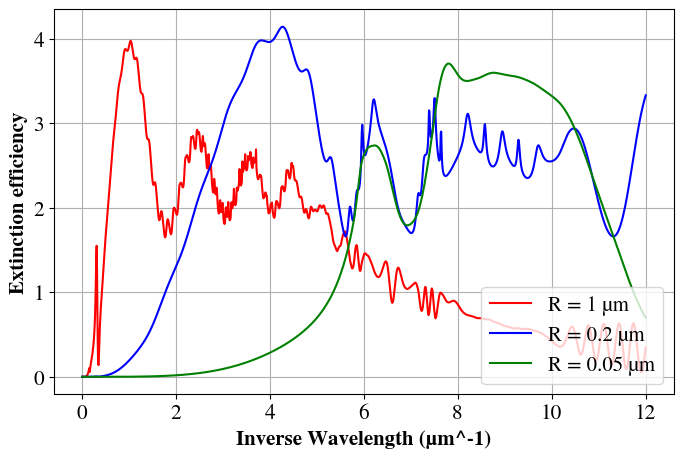

In [241]:
#x = np.linspace(0.1, 4) # set nr to 4 for all wavelengths 
C1, e, m = inter_pw.getCrossSection(type="extinction", dims=1, radius = 1, wavelength = wl, nr = nr, includeParts=True, plot=False)
C2, e2, m2 = inter_pw.getCrossSection(type="extinction", dims=1, radius = 0.2, wavelength = wl, nr = nr, includeParts=True, plot=False)
C3, e3, m3 = inter_pw.getCrossSection(type="extinction", dims=1, radius = 0.05, wavelength = wl, nr = nr, includeParts=True, plot=False)
plt.figure(figsize=(8, 5))
plt.plot(1/wl, C1/(np.pi*1**2), linewidth=1.5, color='red', label=f"R = 1 µm")
plt.plot(1/wl, C2/(np.pi*0.2**2), linewidth=1.5, color='blue', label=f"R = 0.2 µm")
plt.plot(1/wl, C3/(np.pi*0.05**2), linewidth=1.5, color='green', label=f"R = 0.05 µm")
for i in range(len(e)):
    pass
    #plt.plot(x/(2*np.pi*0.2), e[i]/(np.pi*0.2**2), linewidth=1, linestyle='--', alpha=0.8, label = f"Electric contribution j={i+1}")
    #plt.plot(x/(2*np.pi*0.2), m[i]/(np.pi*0.2**2), linewidth=1, linestyle='--', alpha=0.8, label = f"Magnetic contribution j={i+1}")
#plt.axvline(1.32, color='red', linestyle='--', label='1.32 µm')
plt.ylabel("Extinction efficiency")
plt.xlabel("Inverse Wavelength (µm^-1)")
plt.legend(loc="lower right")
plt.grid(True)

In [235]:
C = focused_beam.C_jlp()[0]
maxJ = 25
C = np.ones(maxJ+1)
C = C[1:, None]
L = np.arange(1, len(C)+1)

coefs = (2*L+1)[:, None]  # Ensure coefs is 2D for broadcasting
print("C shape:", C.shape, "coefs shape:", coefs.shape)
prefac = (coefs * np.abs(C)**2).T
print("prefac shape:", prefac.shape)
wl = np.linspace(0.4, 1, 10000)
R = 1.3
nr = 1.5
x = 2 * np.pi * R / wl  # Convert radius to size parameter x
mie = glmt(maxJ, wl, np.asarray(nr), x)
#calculate mie coefficients as a function of x
a = mie.a_j()
b = mie.b_j()
c = mie.c_j()
d = mie.d_j()

k = 2 * np.pi / wl


# Expand prefac to match the shape of a for broadcasting
while prefac.ndim -1 < a.ndim:
    prefac = np.expand_dims(prefac, axis=-1)
print("prefac shape after expansion:", prefac.shape)
print("a shape:", a.shape, "b shape:", b.shape)
Ws = prefac * np.expand_dims(np.abs(a[1:])**2 + np.abs(b[1:])**2 , axis = 0) # [J, mZ, x, nr]
print("Ws shape before sum:", Ws.shape)
Ws = np.sum(Ws, axis=(0, 1)) #sum over J and mZ
Ws = Ws/x**2 # [x, nr]


C shape: (25, 1) coefs shape: (25, 1)
prefac shape: (1, 25)
prefac shape after expansion: (1, 25, 1)
a shape: (26, 10000) b shape: (26, 10000)
Ws shape before sum: (1, 25, 10000)


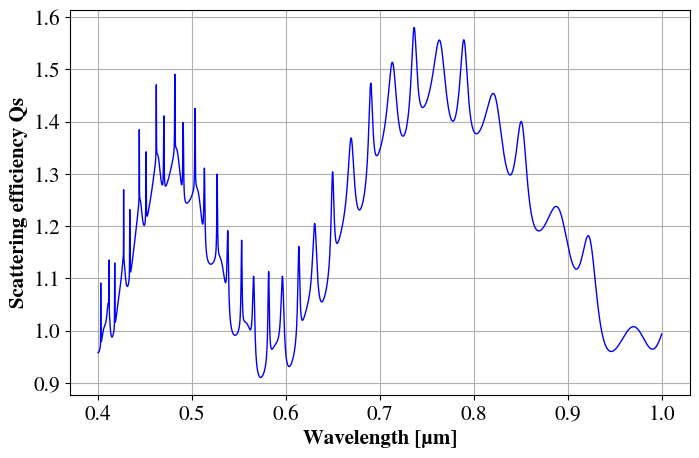

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(wl, Ws, linewidth=1, color='blue')
#plt.plot(wl, np.abs(b[20])**2, linewidth=1, color='red')
plt.xlabel("Wavelength [µm]")
plt.ylabel("Scattering efficiency Qs")
plt.grid(True)

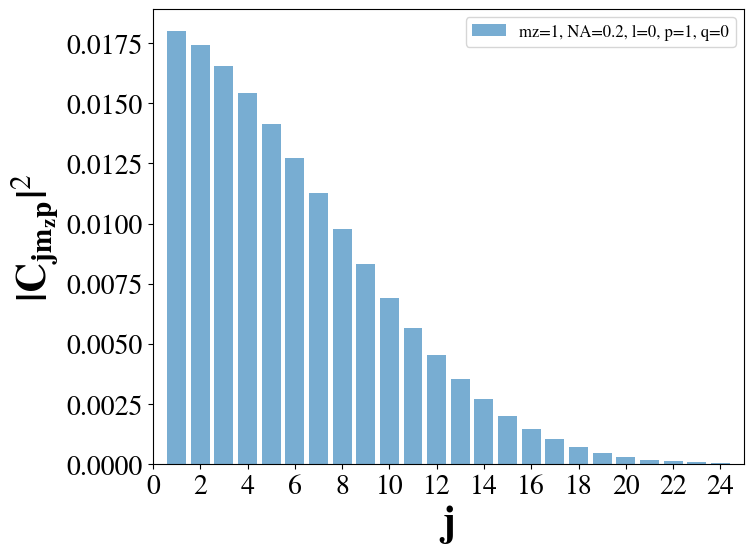

In [4]:
focused_beam.plot_Cjl()

In [14]:
wl = np.linspace(0.4, 1, 10000)
Cscat = inter.getCrossSection(type="scattering", nr = 1.5, radius = 1.3, wavelength = wl)
Cscat.shape

(10000,)

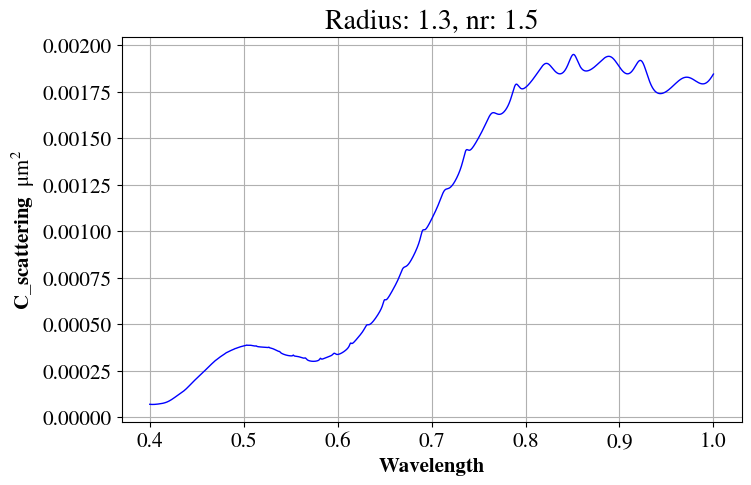

In [15]:
inter.plotCrossSection(type="scattering", wavelength = wl)

TypeError: Invalid shape (10000,) for image data

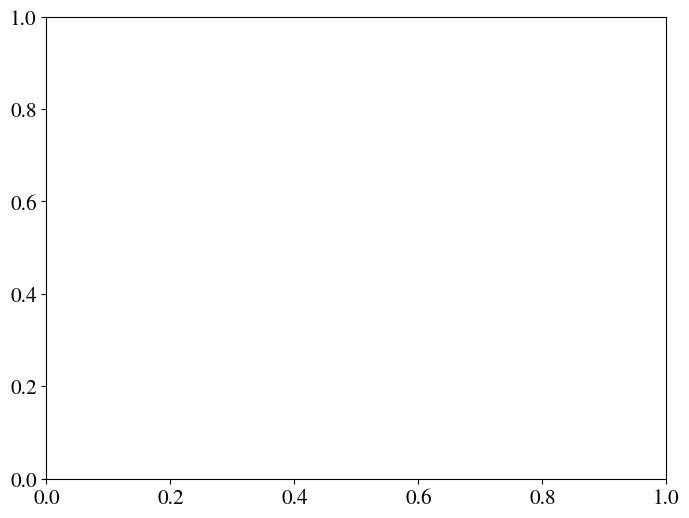

In [201]:
plt.figure(figsize=(8, 6))
plt.imshow(Cscat, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Cscat')
plt.xlabel('Radius Index')
plt.ylabel('Refractive Index Index')
plt.title('2D Colorplot of Cscat')
plt.show()

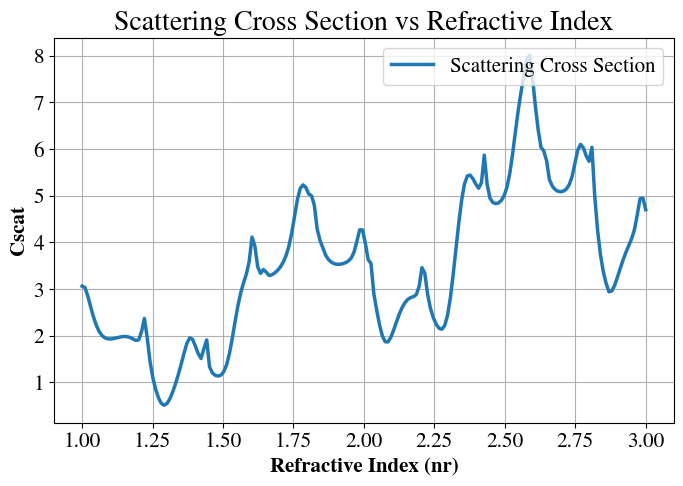

In [125]:
nr = np.linspace(1, 3, 200)
plt.figure(figsize=(8, 5))
plt.plot(nr, Cscat, label='Scattering Cross Section')
plt.xlabel('Refractive Index (nr)')
plt.ylabel('Cscat')
plt.title('Scattering Cross Section vs Refractive Index')
plt.legend()
plt.grid(True)
plt.show()

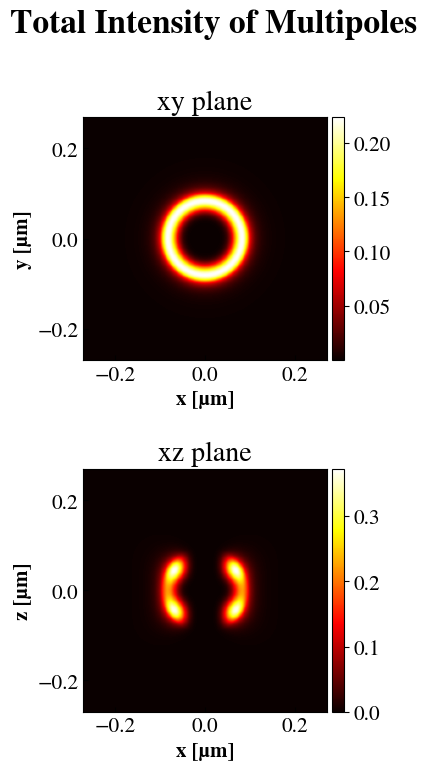

In [4]:
inter.plot_int(plot="total", globalnorm=False)

In [2]:
dom = domain(4, planes={"xy", "yz"})
wl = 0.632

#define displacement vector in microns
disp_vec = np.array([0, 0.8, 0]) #0.8µm displacement in y
wl = 0.632

#polarisation
p = 1

#maximum order (for initialization)
maxJ = 25

#initialize BeamDisplacement object
disp = BeamDisplacement(dom, disp_vec, wl, p, maxJ, NA=0.9, f=1000, n_lens=1)

The (2j+1)Cjm_z normalization yields 1.996591
The LG integral on the aplanatic lens surface is 0.998

Loaded CG1 and CG2 from file.


In [53]:
dom.planes

{'xy', 'yz'}

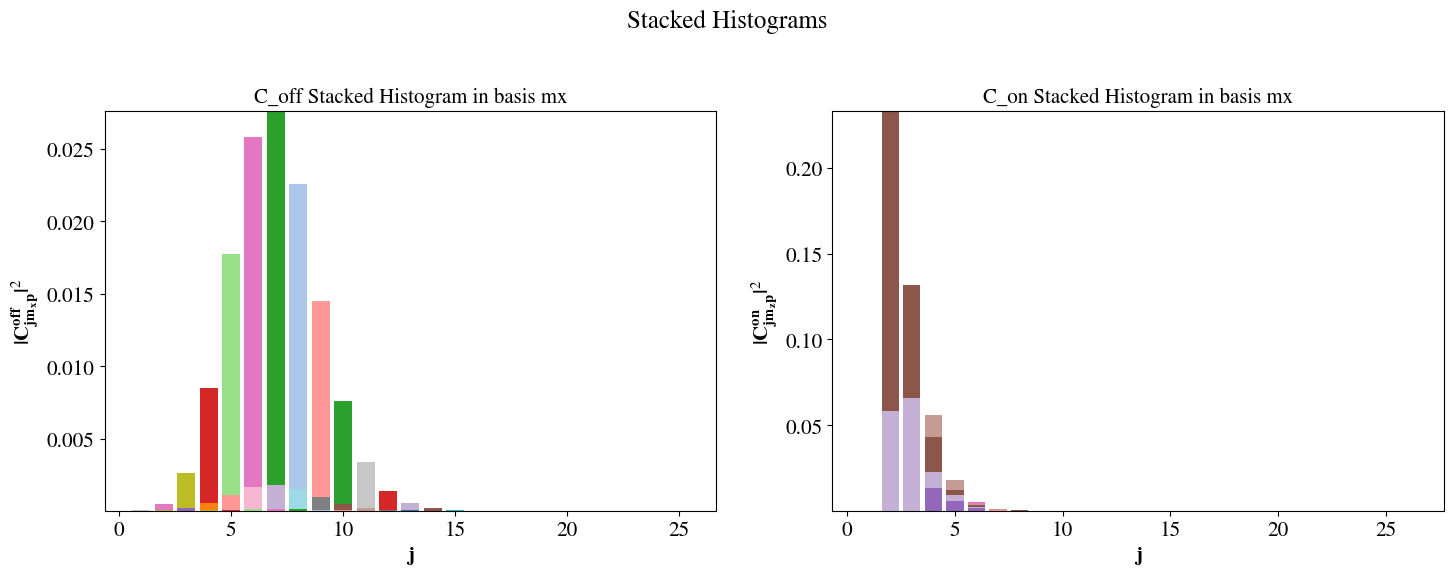

In [54]:
# plot in mx basis
disp.plot_stacked_histograms(basis = "mx")

In [3]:
inter =interaction(disp, domain=dom, nr=1.5, radius=0.75, mu=1.0, mu1=1.0, interaction="both")

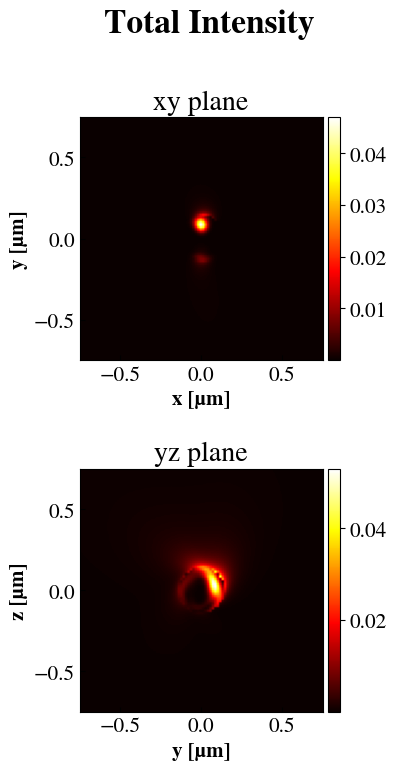

In [4]:
inter.plot_int(plot="total", globalnorm=False)